In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
# https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024?resource=download

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DS675

/content/drive/MyDrive/DS675


In [ ]:
earth_data = pd.read_csv('/content/drive/MyDrive/DS675/nearest-earth-objects.csv')
earth_data.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [ ]:
earth_data.shape


(338199, 9)

In [ ]:
earth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [ ]:
earth_data.isnull().sum()

,0
neo_id,0
name,0
absolute_magnitude,28
estimated_diameter_min,28
estimated_diameter_max,28
orbiting_body,0
relative_velocity,0
miss_distance,0
is_hazardous,0


In [ ]:
earth_data.duplicated().sum()


0

In [ ]:
earth_data["name"].value_counts()


,count
name,
277810 (2006 FV35),211
469219 Kamo`oalewa (2016 HO3),197
(2014 OL339),192
(2017 FZ2),186
(2023 FW13),169
...,...
(2024 MX),1
(2024 LR2),1
(2024 MW1),1


In [ ]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.7 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [ ]:
numerical_summary = earth_data.describe()
numerical_summary

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338171.000000,338171.000000,338171.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157812,0.352878,51060.662908,4.153535e+07
std,2.287225e+07,2.911216,0.313885,0.701869,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [ ]:
pd.DataFrame(earth_data["name"].value_counts()[0:10])


,count
name,
277810 (2006 FV35),211
469219 Kamo`oalewa (2016 HO3),197
(2014 OL339),192
(2017 FZ2),186
(2023 FW13),169
(2022 YF4),151
164207 (2004 GU9),135
85770 (1998 UP1),101
138852 (2000 WN10),99


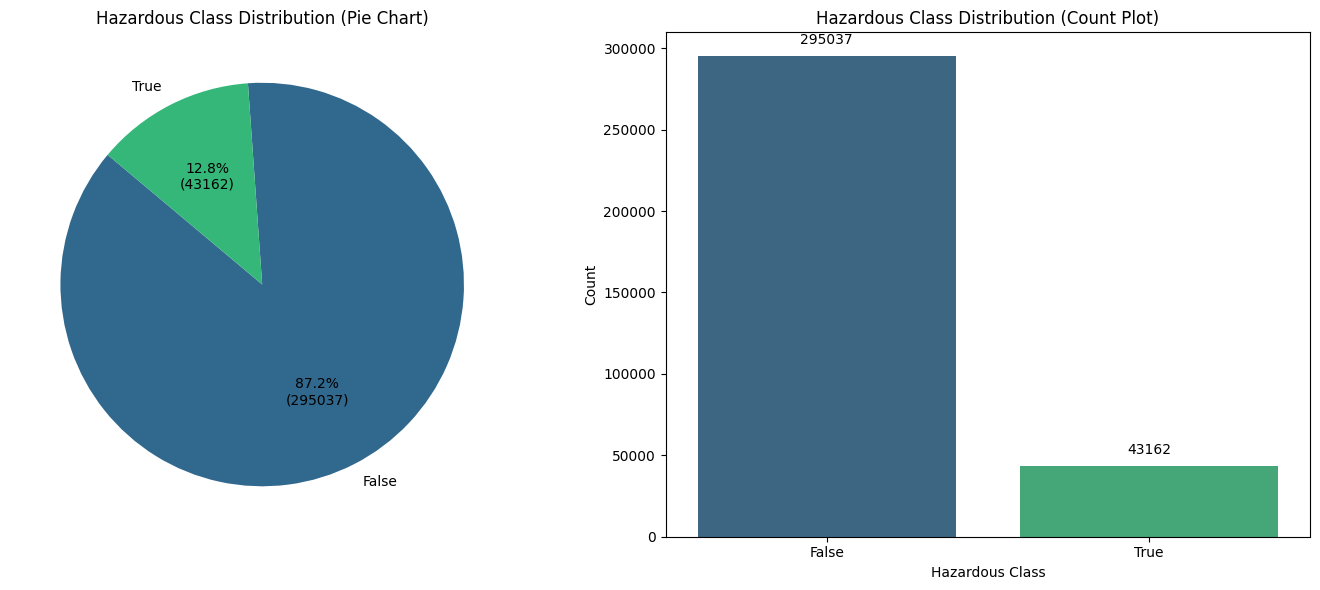

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'earth_data' is already defined
hazardous_counts = earth_data['is_hazardous'].value_counts().sort_index()

# Define color palette
palette = sns.color_palette("viridis", n_colors=len(hazardous_counts))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie Chart
ax1.pie(hazardous_counts, labels=earth_data["is_hazardous"].unique(),
        autopct=lambda p: f'{p:.1f}%\n({int(round(p * hazardous_counts.sum() / 100))})',
        startangle=140, colors=palette)
ax1.set_title('Hazardous Class Distribution (Pie Chart)')

# Bar Chart
sns.countplot(x='is_hazardous', data=earth_data, ax=ax2, palette=palette)
for idx, count in enumerate(hazardous_counts):
    ax2.text(idx, count + hazardous_counts.max() * 0.02, f'{count}', ha='center', va='bottom', fontsize=10)
ax2.set_title('Hazardous Class Distribution (Count Plot)')
ax2.set_xlabel('Hazardous Class')
ax2.set_ylabel('Count')
ax2.set_xticklabels(earth_data["is_hazardous"].unique())

# Adjust layout
plt.tight_layout()
plt.show()


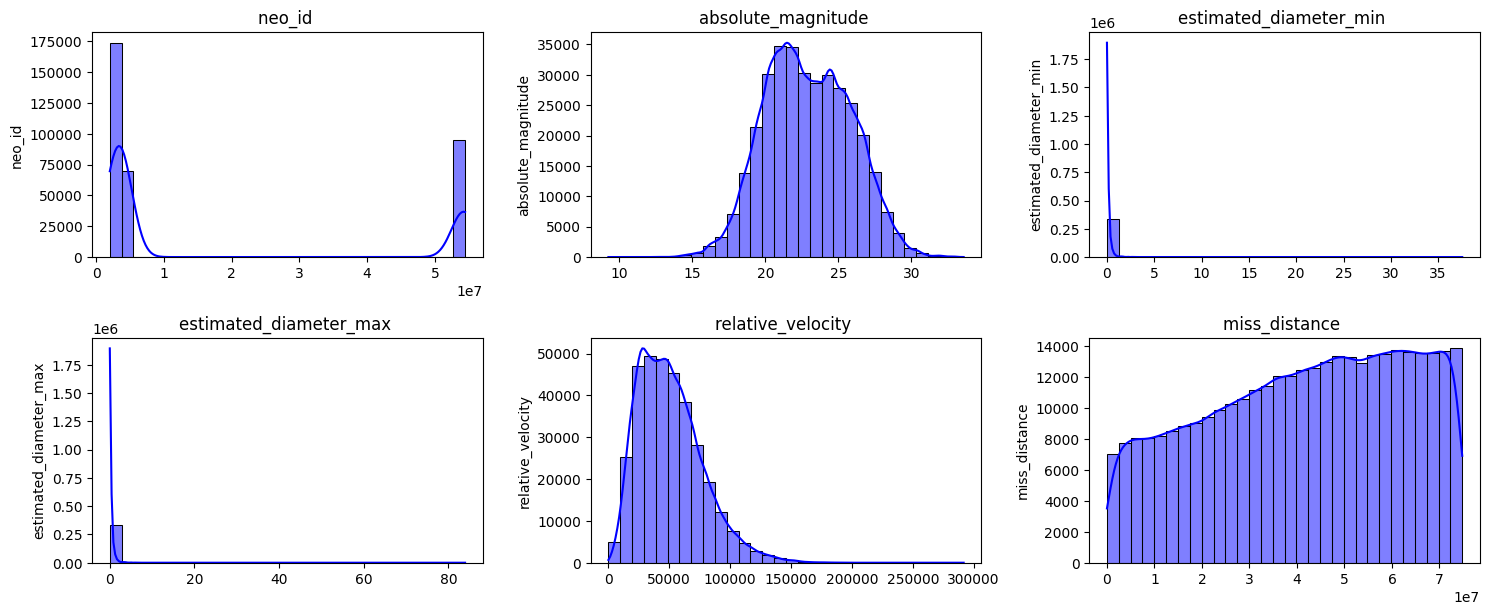

In [ ]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(earth_data.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.histplot(data=earth_data, x=feature, bins=30, kde=True, color='blue')
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

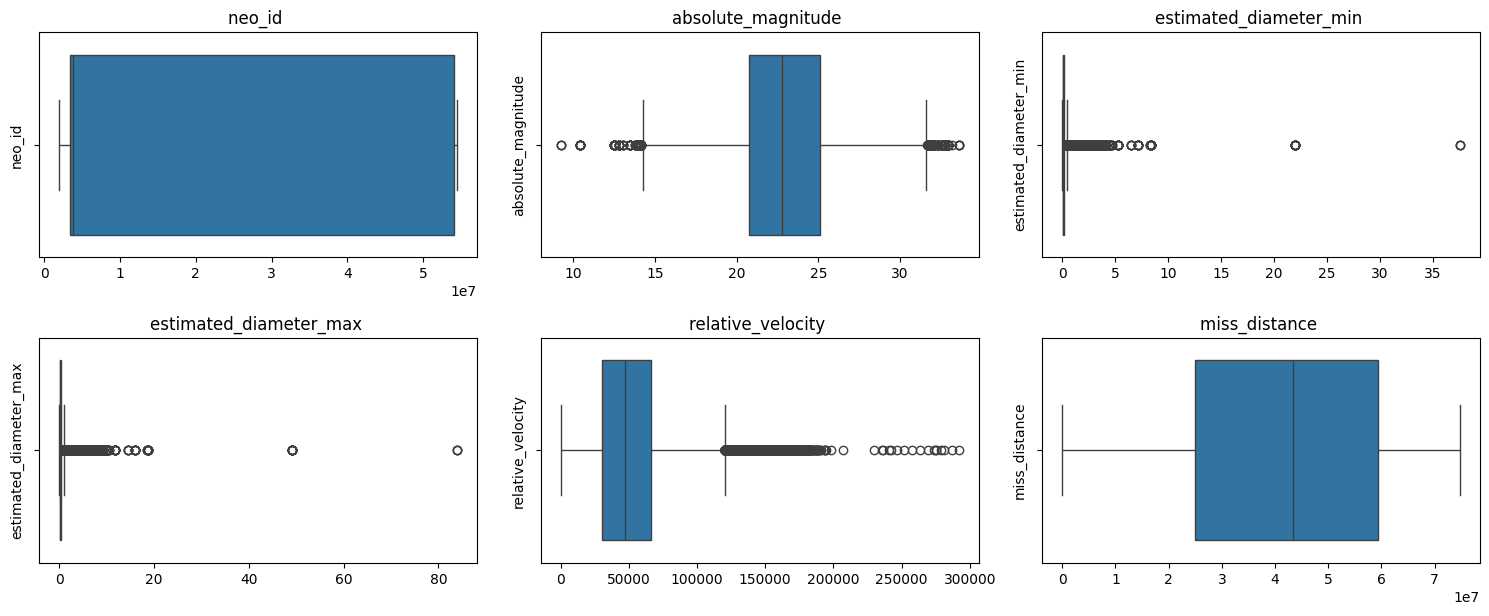

In [ ]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(earth_data.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=earth_data, x=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

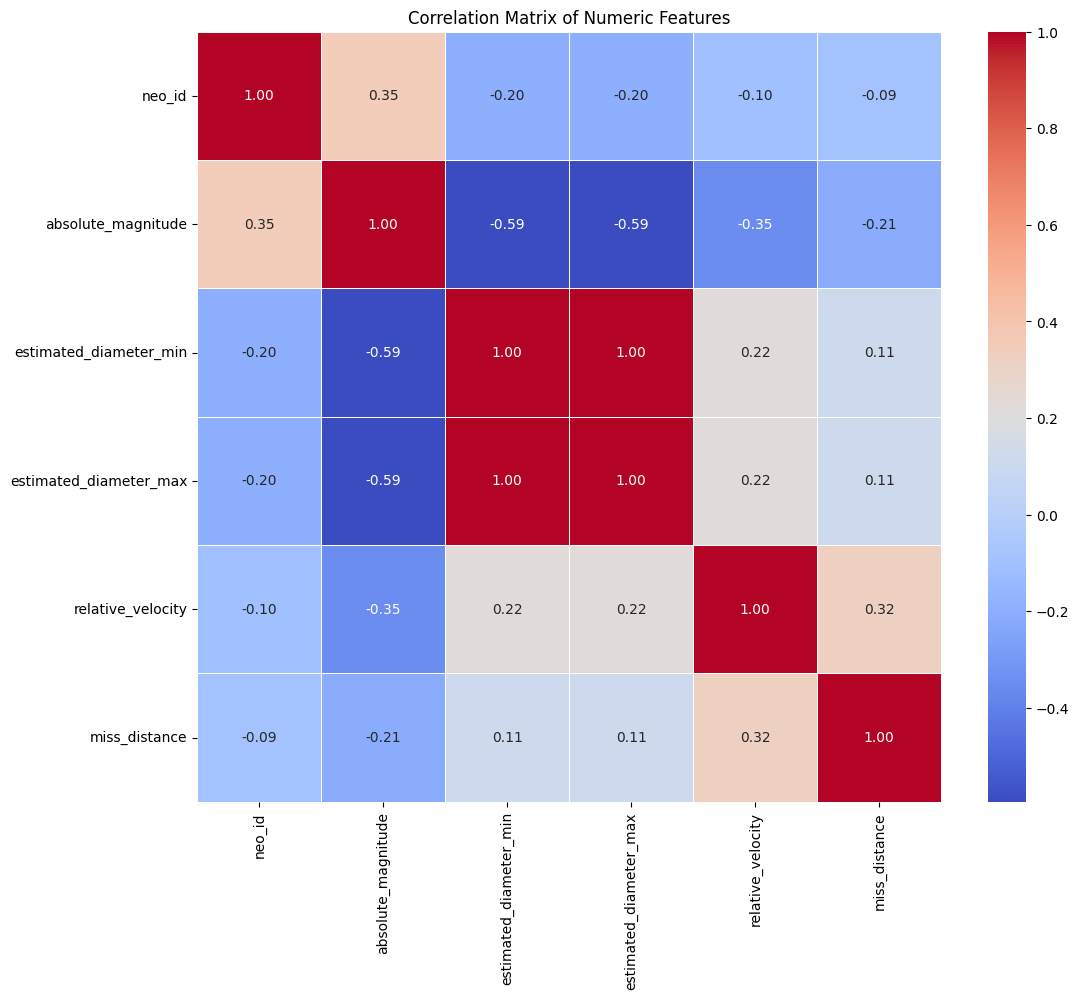

In [ ]:
# Select only numeric columns
numeric_data = earth_data.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


In [ ]:
# Ensure only numeric columns are used, including the target variable
numeric_data = earth_data.select_dtypes(include=['number'])

# Check if the target column is present and numeric
if 'is_hazardous' in numeric_data.columns:
    # Correlation of features with the target variable
    correlation_with_target = numeric_data.corr()['is_hazardous'].sort_values(ascending=False)

    # Display the correlation values
    print("Correlation with the target variable:")
    print(correlation_with_target)

    # Plot the correlation values
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')
    plt.title('Correlation of Features with Target Variable')
    plt.xlabel('Features')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("The target column 'is_hazardous' is not numeric or not found in the dataset.")


The target column 'is_hazardous' is not numeric or not found in the dataset.


In [ ]:
## Missing values
earth_data.dropna(inplace=True)

In [ ]:
# removing outliers
def remove_outliers(feature):
    global earth_data
    q1 = earth_data[feature].quantile(0.25)
    q3 = earth_data[feature].quantile(0.65)
    iqr = q3 - q1

    upper_limit = q3 + (1.5 * iqr)
    lower_limit = q1 - (1.5 * iqr)

    earth_data = earth_data.loc[(earth_data[feature] < upper_limit) & (earth_data[feature] > lower_limit)]

In [ ]:
features_list = ["absolute_magnitude", "estimated_diameter_min", "estimated_diameter_max", "relative_velocity"]

for feature in features_list:
    remove_outliers(feature)

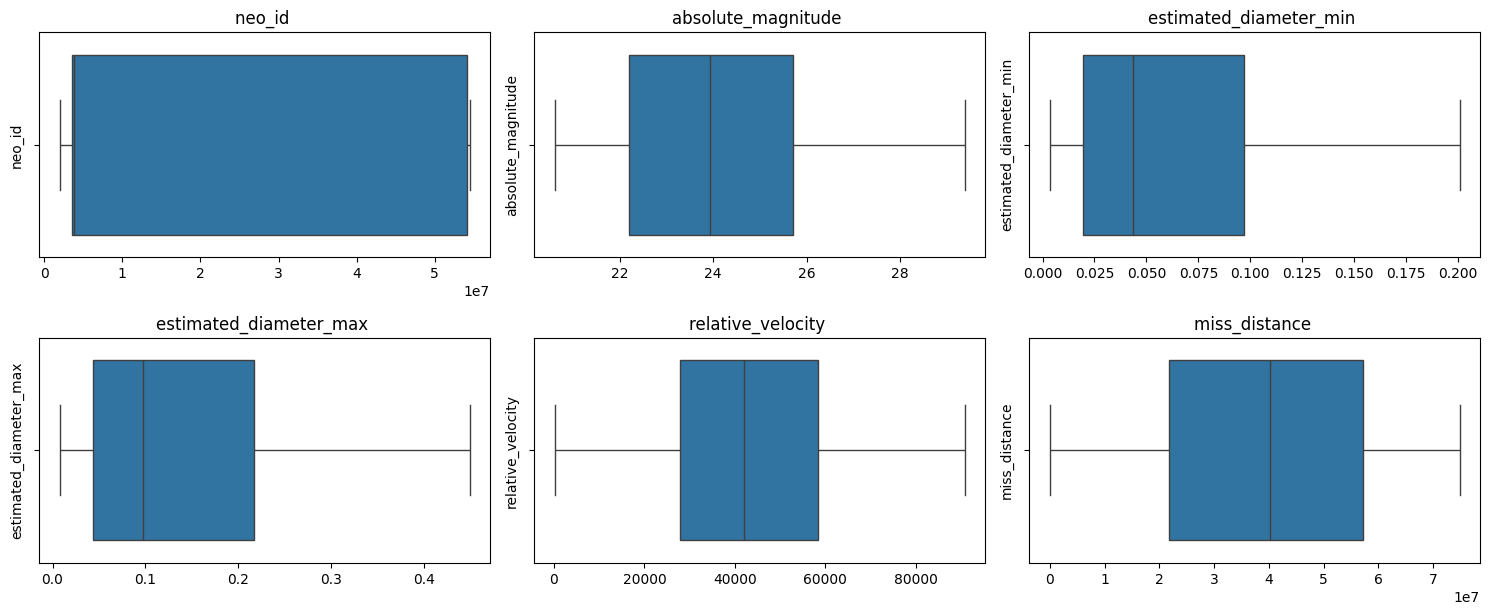

In [ ]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(earth_data.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=earth_data, x=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

In [ ]:
X = earth_data.drop(["neo_id", "name", "orbiting_body", "is_hazardous"], axis=1)

y = earth_data["is_hazardous"]

In [ ]:
print(y.value_counts())

is_hazardous
False    225477
True      18974
Name: count, dtype: int64


##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model
dt_classifier.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [ ]:
# Predict on the test set
y_pred = dt_classifier.predict(X_test)


Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.96      0.96     67644
        True       0.55      0.56      0.55      5692

    accuracy                           0.93     73336
   macro avg       0.76      0.76      0.76     73336
weighted avg       0.93      0.93      0.93     73336


Confusion Matrix:


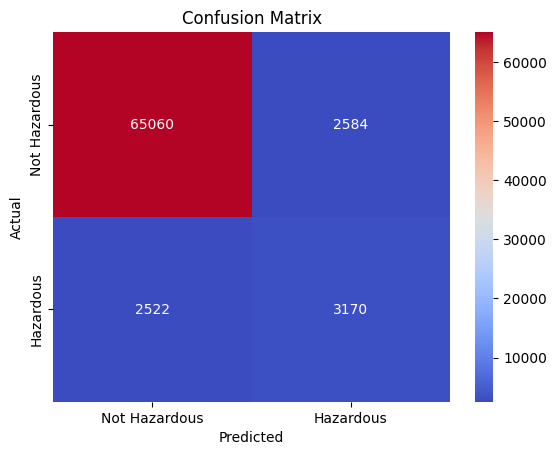

In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.96      0.96     67644
        True       0.55      0.56      0.55      5692

    accuracy                           0.93     73336
   macro avg       0.76      0.76      0.76     73336
weighted avg       0.93      0.93      0.93     73336

AUC-ROC Score: 0.76


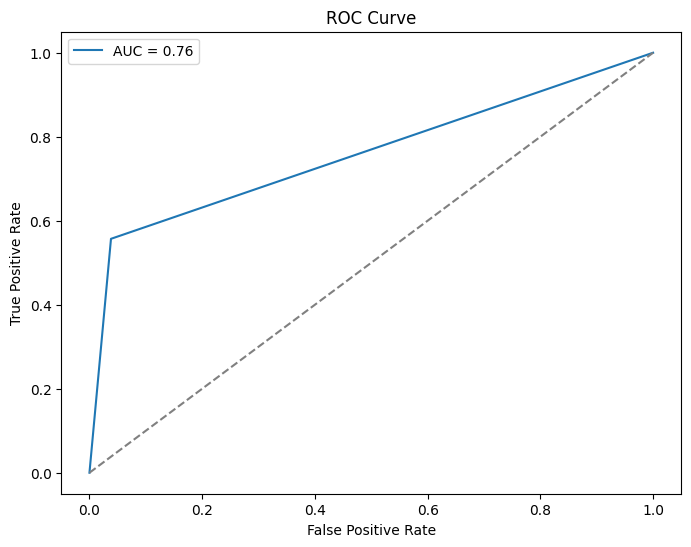

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# F1-score and Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
y_prob = dt_classifier.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {roc_auc:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
print(X_test.columns)


Index(['absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'relative_velocity', 'miss_distance'],
      dtype='object')


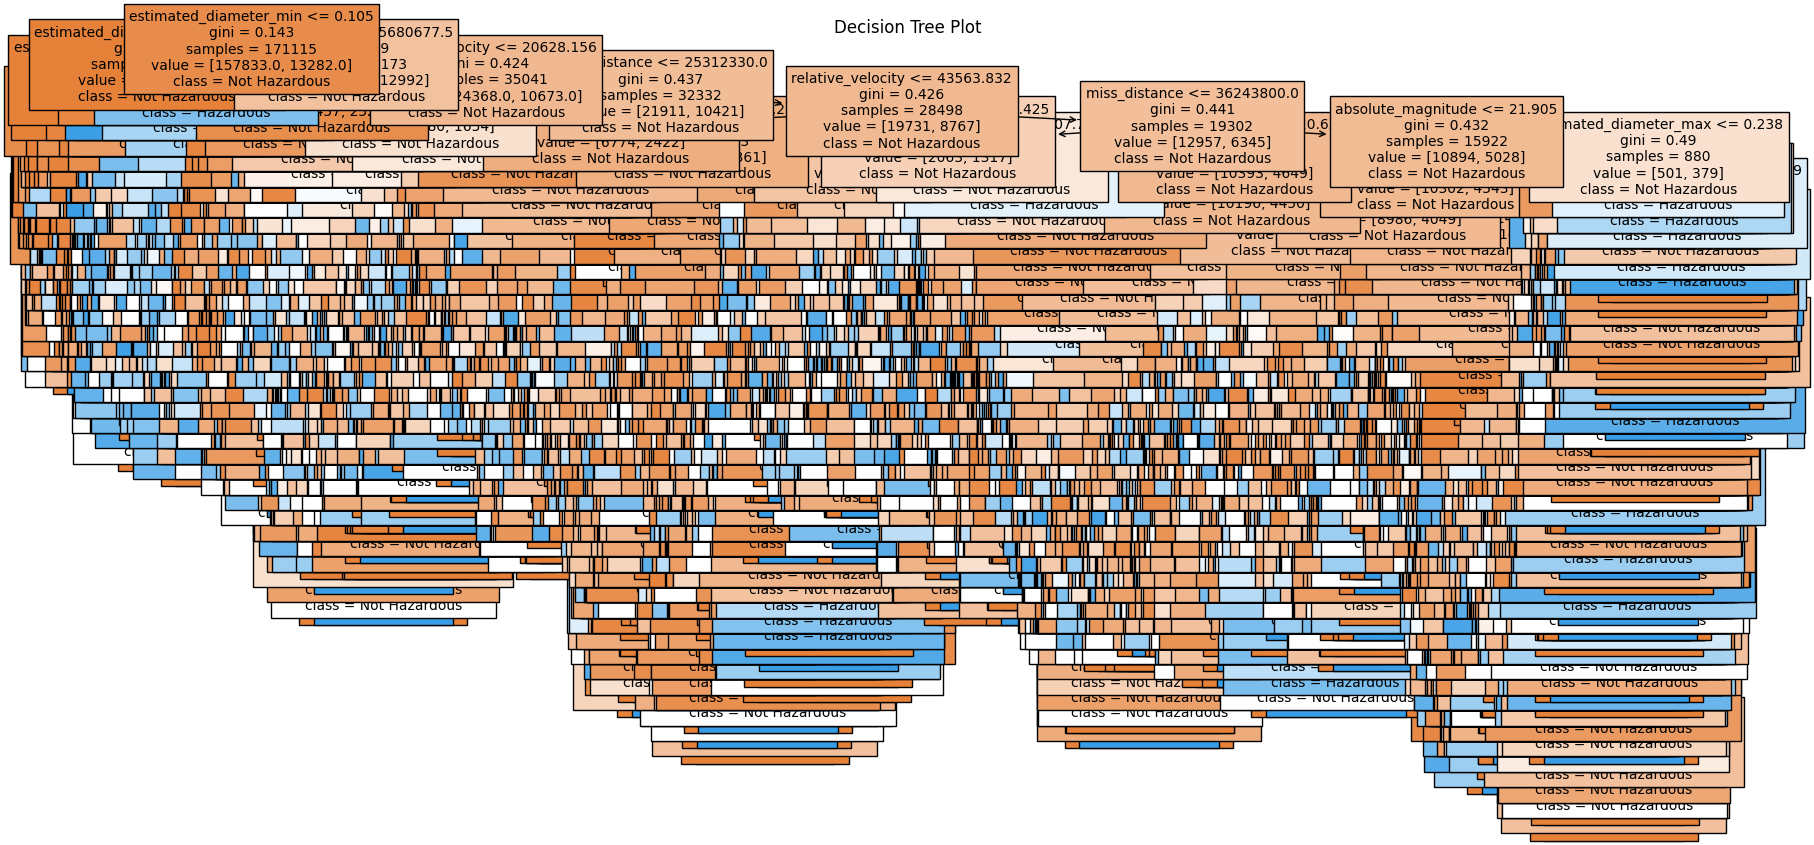

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X.columns, class_names=["Not Hazardous", "Hazardous"], filled=True, fontsize=10)
plt.title("Decision Tree Plot")
plt.show()


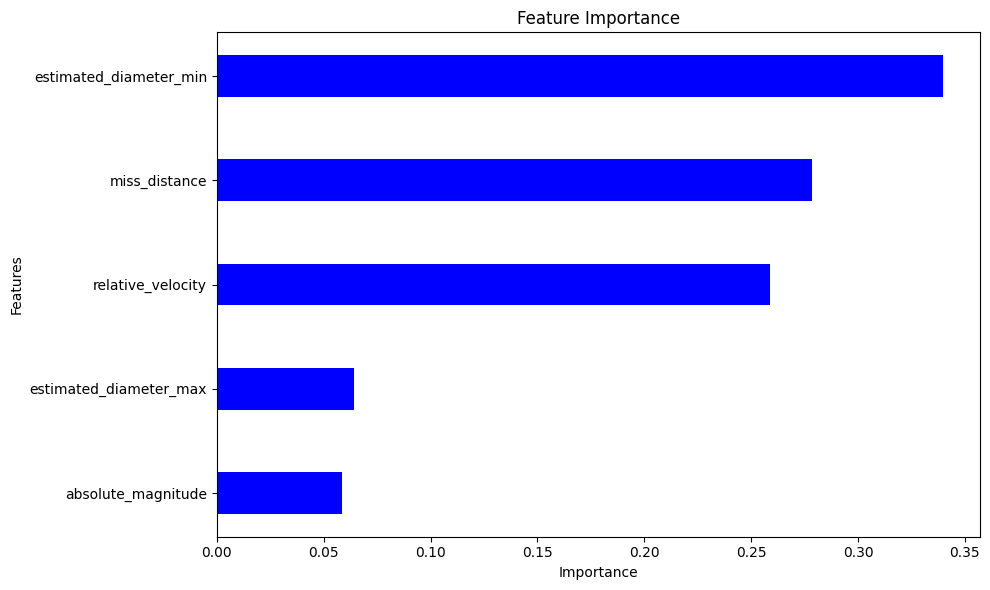

In [ ]:
feature_importances = dt_classifier.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['Feature'], importance_df['Importance'], color='blue', height=0.4)
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')
plt.tight_layout()
plt.show()

##DTC Using Smote

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check class distribution
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution before SMOTE:
is_hazardous
False    157833
True      13282
Name: count, dtype: int64
Class distribution after SMOTE:
is_hazardous
False    157833
True     157833
Name: count, dtype: int64


In [ ]:
# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_smote, y_train_smote)

# Predictions on the test set
y_pred = dt_classifier.predict(X_test)

In [ ]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.96      0.97     67644
        True       0.59      0.63      0.61      5692

    accuracy                           0.94     73336
   macro avg       0.78      0.80      0.79     73336
weighted avg       0.94      0.94      0.94     73336



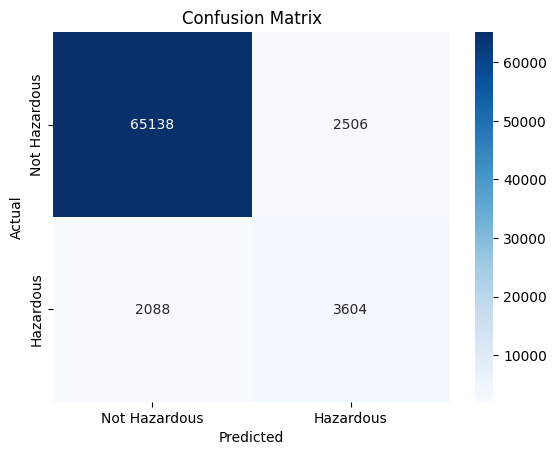

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

AUC-ROC Score: 0.80


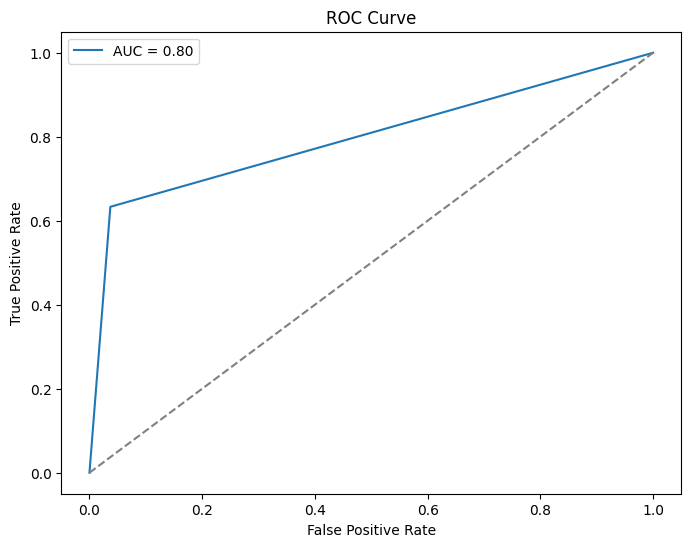

In [ ]:
# AUC-ROC
y_prob = dt_classifier.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Hyperparam

In [ ]:
# Step 3: Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Step 4: Instantiate the Decision Tree Classifier and RandomizedSearchCV
clf = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=50,  # Number of random configurations to try
    scoring='f1',  # Optimize for F1 score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [ ]:

# Step 5: Perform RandomizedSearchCV on the SMOTE data
random_search.fit(X_train_smote, y_train_smote)

# Step 6: Best parameters and evaluation
best_clf = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}


In [ ]:
# Step 7: Test set evaluation
y_pred = best_clf.predict(X_test)

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.97      0.97     67644
        True       0.61      0.58      0.59      5692

    accuracy                           0.94     73336
   macro avg       0.79      0.77      0.78     73336
weighted avg       0.94      0.94      0.94     73336



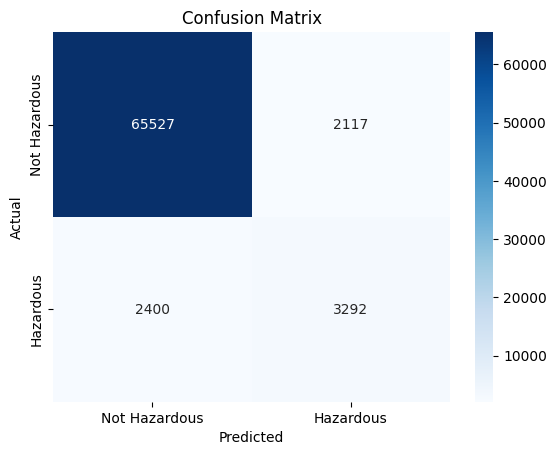

In [ ]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

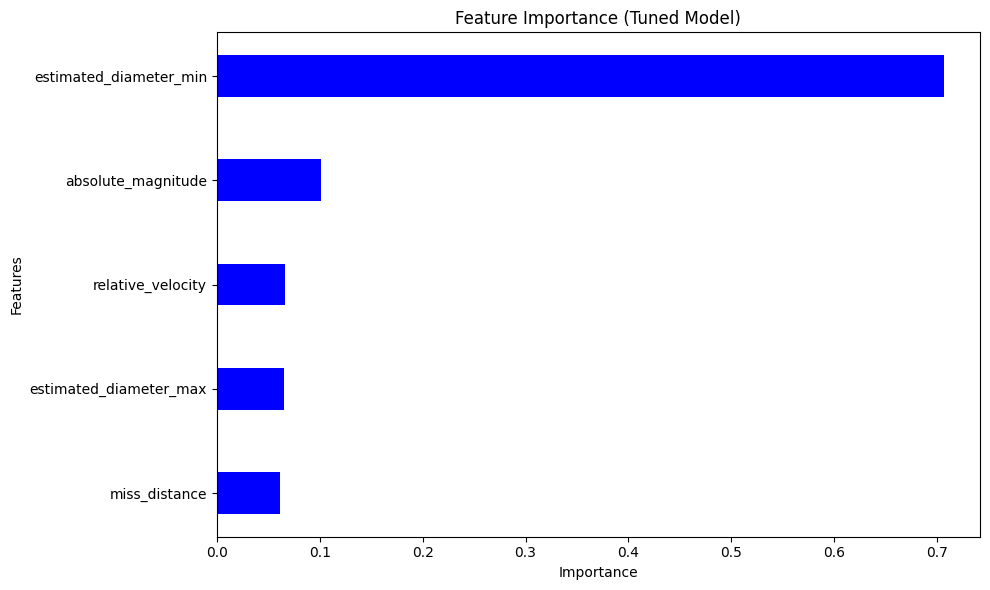

In [ ]:
# Feature Importance
feature_importances = best_clf.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['Feature'], importance_df['Importance'], color='blue', height=0.4)
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance (Tuned Model)')
plt.tight_layout()
plt.show()

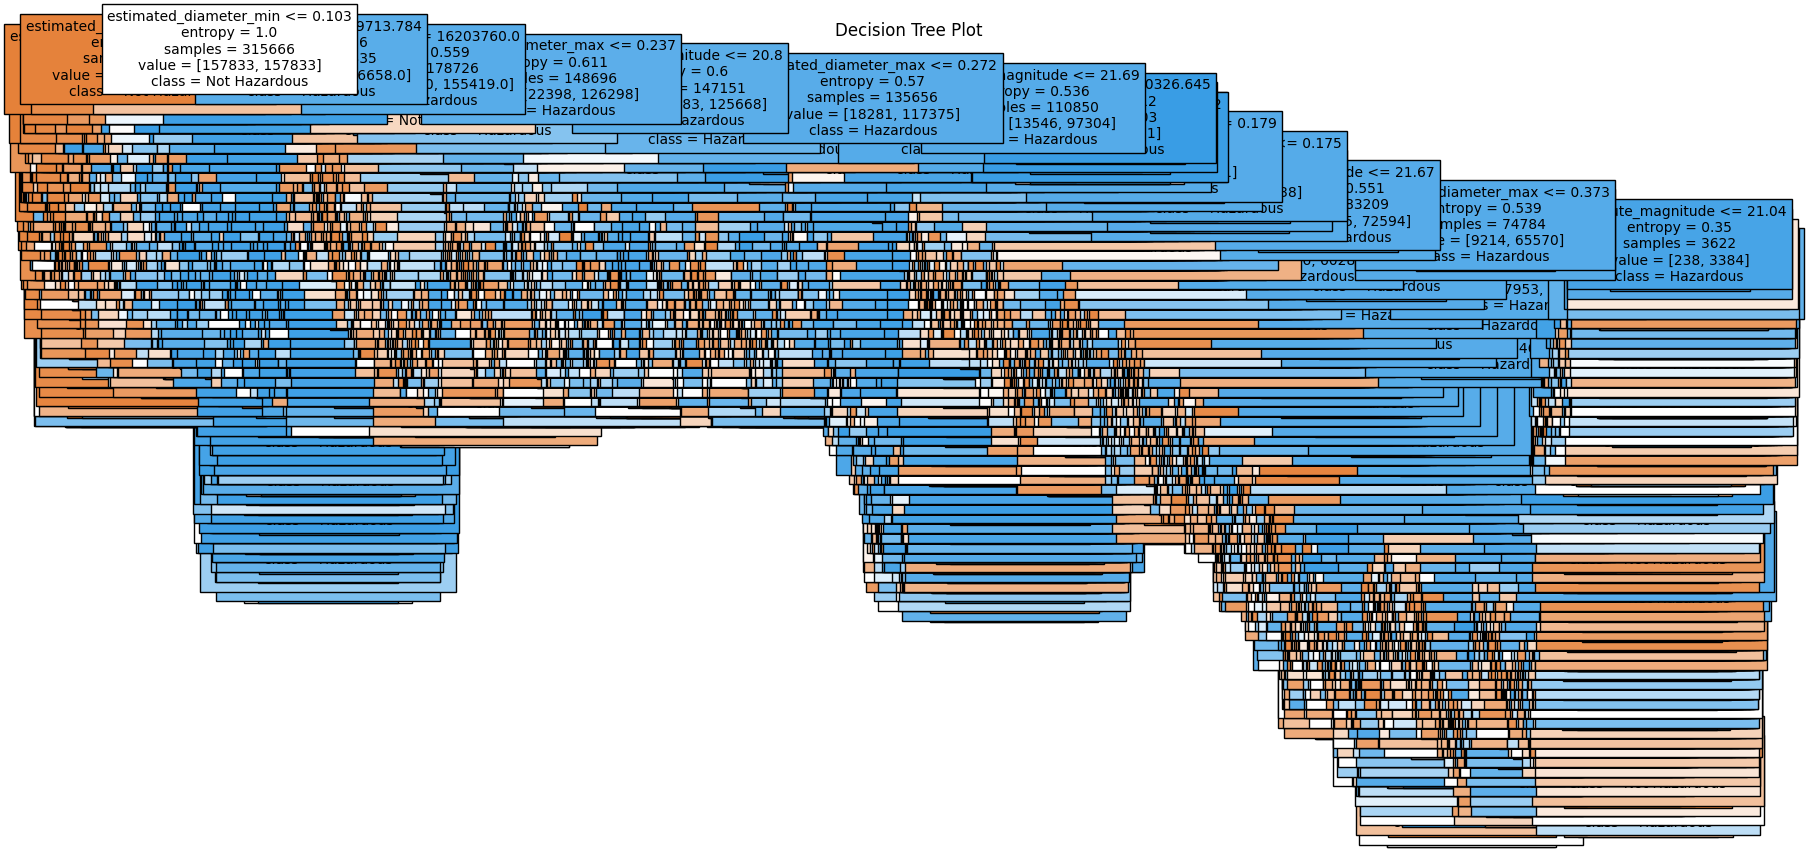

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=X.columns, class_names=["Not Hazardous", "Hazardous"], filled=True, fontsize=10)
plt.title("Decision Tree Plot")
plt.show()


## Random Forest Using Smote

In [ ]:
somte = SMOTE(random_state=42)

X_resampled, y_resampled = somte.fit_resample(X, y)

y_resampled.value_counts()

,count
is_hazardous,
False,225477
True,225477


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((195560, 5), (195560,), (48891, 5), (48891,))

In [ ]:
clf = RandomForestClassifier(random_state=42)


In [ ]:
clf.fit(x_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(x_test)


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.97      0.98      0.97     45096
        True       0.70      0.60      0.64      3795

    accuracy                           0.95     48891
   macro avg       0.84      0.79      0.81     48891
weighted avg       0.95      0.95      0.95     48891



In [ ]:
print("Acc is: {} %".format(accuracy_score(y_pred, y_test) * 100))


Acc is: 94.9131742038412 %


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[44145   951]
 [ 1536  2259]]


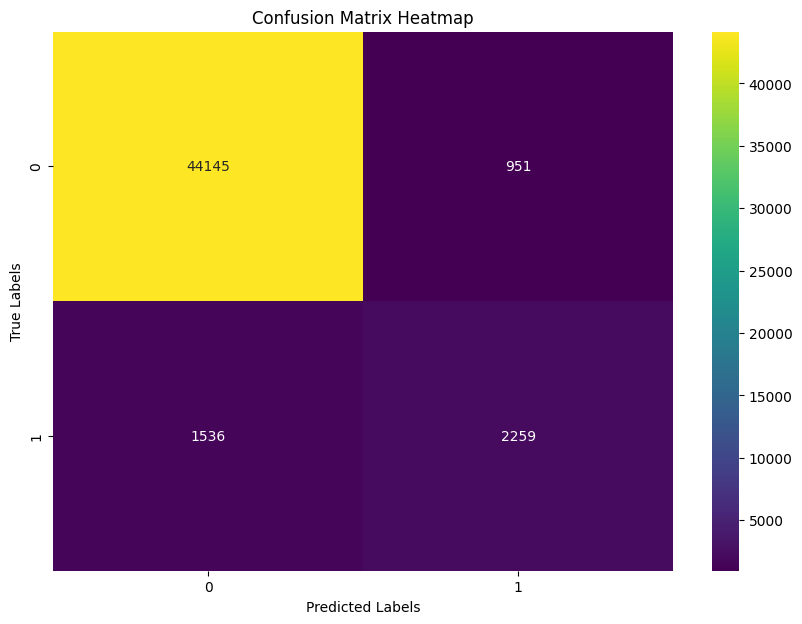

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

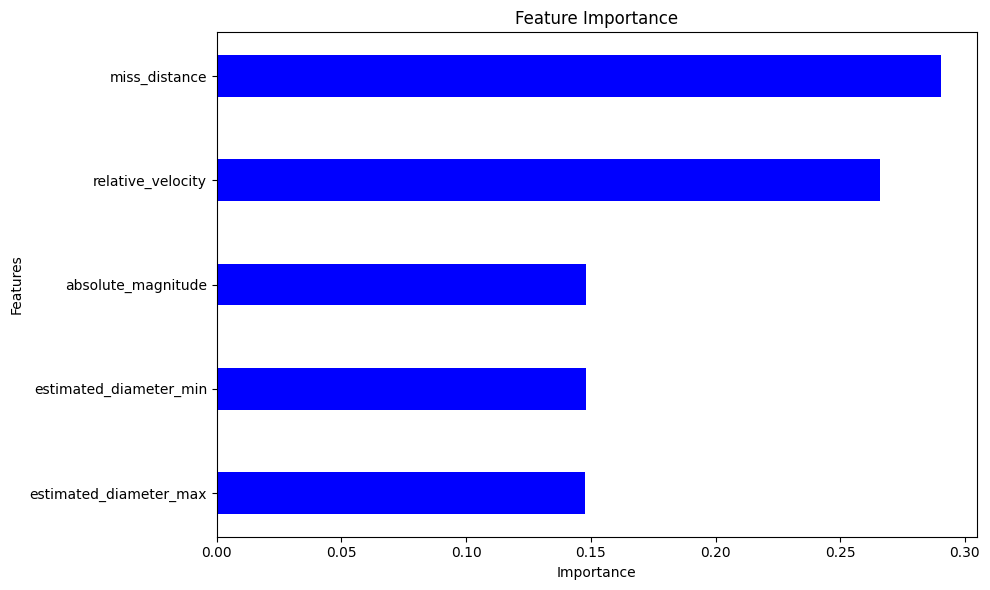

In [ ]:
feature_importances = clf.feature_importances_
feature_names = x_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['Feature'], importance_df['Importance'], color='blue', height=0.4)
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')
plt.tight_layout()
plt.show()

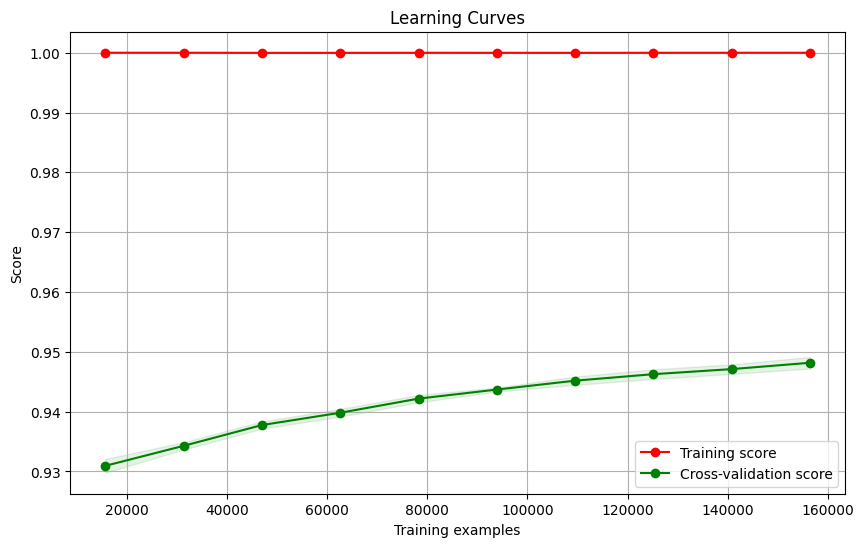

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    clf, x_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

## Random Forest Using Smote (with Hyperparameters)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# Apply GridSearchCV for hyperparameter tuning
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, scoring='accuracy')
rf_grid_search.fit(x_train, y_train)  # Use x_train and y_train

# Get the best model
rf_best_model = rf_grid_search.best_estimator_
print(f"Best Random Forest Model: {rf_grid_search.best_params_}")

Best Random Forest Model: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


Random Forest Confusion Matrix:
[[44726   370]
 [ 2624  1171]]
Random Forest F1-Score: 0.44
Random Forest AUC-ROC: 0.96


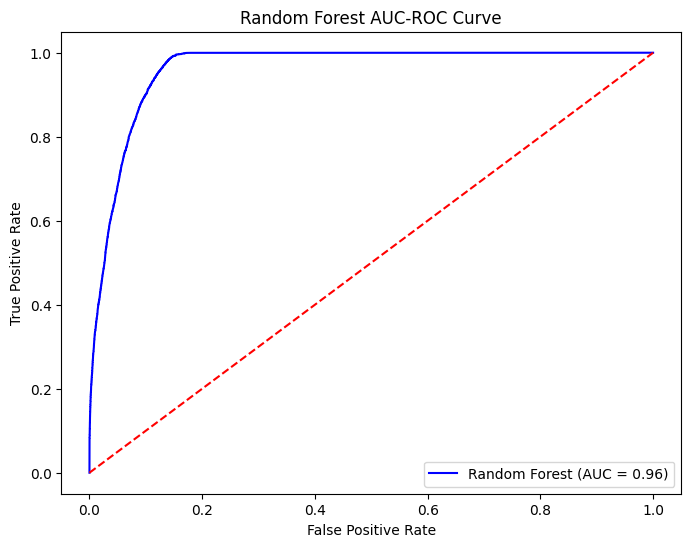

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict using the best Random Forest model
rf_predictions = rf_best_model.predict(x_test)  # Use x_test

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predictions)  # Use y_test
print("Random Forest Confusion Matrix:")
print(rf_cm)

# F1-Score
rf_f1 = f1_score(y_test, rf_predictions)
print(f"Random Forest F1-Score: {rf_f1:.2f}")

# AUC-ROC
rf_auc = roc_auc_score(y_test, rf_best_model.predict_proba(x_test)[:, 1])  # Use x_test
print(f"Random Forest AUC-ROC: {rf_auc:.2f}")

# Plot AUC-ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_best_model.predict_proba(x_test)[:, 1])  # Use x_test
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest AUC-ROC Curve')
plt.legend()
plt.show()

In [ ]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.8 MB/s eta 0:00:00


In [ ]:
print("Acc is: {} %".format(accuracy_score(rf_predictions, y_test) * 100))


Acc is: 93.87617352887034 %


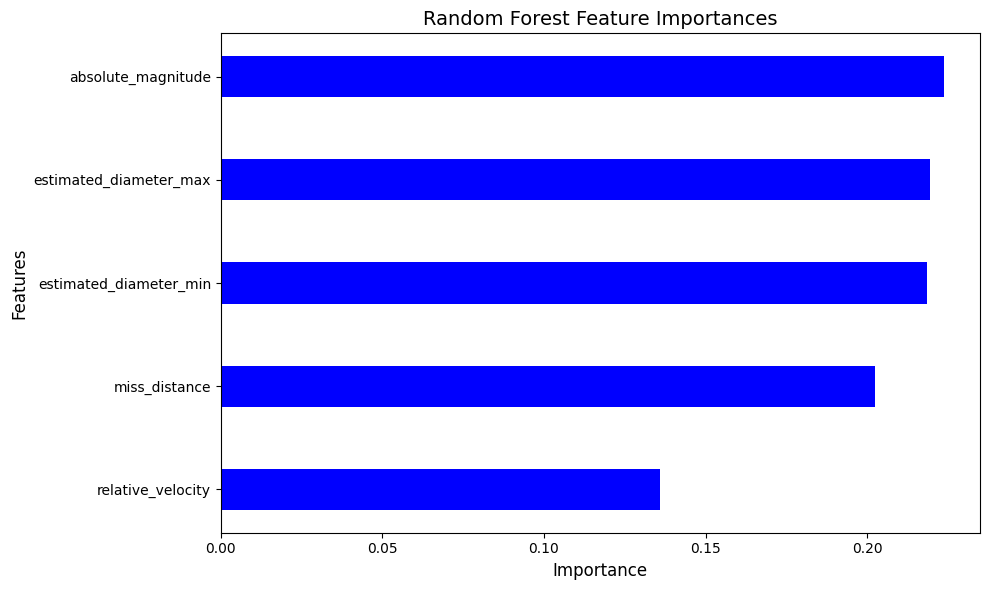

In [ ]:
# Extract feature importances and feature names from the Random Forest model
feature_importances = rf_best_model.feature_importances_
feature_names = x_train.columns  # Ensure these are the column names of x_train

# Create a DataFrame to organize the importance data
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance values in ascending order
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances as a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['Feature'], importance_df['Importance'], color='blue', height=0.4)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Random Forest Feature Importances', fontsize=14)
plt.tight_layout()
plt.show()


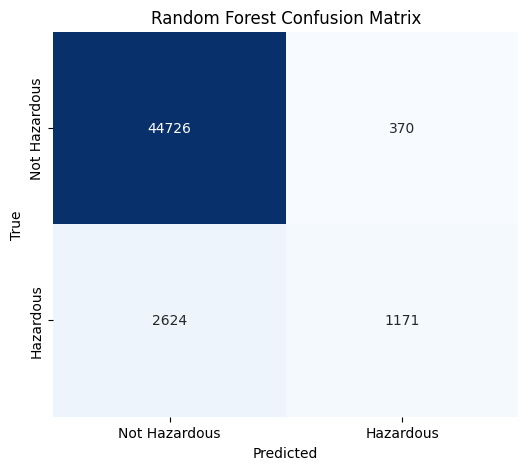

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)  # Use y_test and rf_predictions

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Hazardous', 'Hazardous'],
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()